In [ ]:
!nvidia-smi

Sat Oct  2 17:32:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import os
import time
import datetime

In [ ]:
_URL="https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/cezanne2photo.zip"

In [ ]:
path_to_zip=tf.keras.utils.get_file("cezanne2photo.zip",_URL,extract=True)
PATH=pathlib.Path(path_to_zip)
PATH=PATH.parent/"cezanne2photo"
print(PATH)
print(list(PATH.parent.iterdir()))

279896064/279885071 [==============================] - 56s 0us/step
/root/.keras/datasets/cezanne2photo
[PosixPath('/root/.keras/datasets/cezanne2photo.zip'), PosixPath('/root/.keras/datasets/cezanne2photo')]


In [ ]:
def load(imfile):
  im=tf.io.read_file(imfile)
  im=tf.io.decode_jpeg(im)
  im=tf.cast(im,tf.float32)
  return im

def resize(im):
  im=tf.image.resize(im,[256,256],method="nearest")
  return im

def normalize(im):
  im=(im-127.5)/127.5
  return im

In [ ]:
def loadimageforuse(imfile):
  return resize(normalize(load(imfile)))

In [ ]:
os.listdir(str(PATH))

['testA', 'trainA', 'trainB', 'testB']

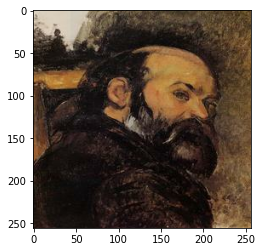

In [ ]:
imfile=PATH/"trainA/00406.jpg"
im=tf.io.read_file(str(imfile))
im=tf.io.decode_jpeg(im)
plt.imshow(im)

In [ ]:
train_dataset_A=tf.data.Dataset.list_files(str(PATH/"trainA/*.jpg"))
train_dataset_B=tf.data.Dataset.list_files(str(PATH/"trainB/*.jpg"))
train_dataset_A=train_dataset_A.map(loadimageforuse)
train_dataset_B=train_dataset_B.map(loadimageforuse)
train_dataset_A=train_dataset_A.shuffle(200).repeat()
train_dataset_B=train_dataset_B.shuffle(200).repeat()
train_dataset_A=train_dataset_A.batch(1)
train_dataset_B=train_dataset_B.batch(1)

In [ ]:
for a in train_dataset_A.take(1):
  print(tf.shape(a))

tf.Tensor([  1 256 256   3], shape=(4,), dtype=int32)


In [ ]:
test_dataset_A=tf.data.Dataset.list_files(str(PATH/"testA/*.jpg"))
test_dataset_B=tf.data.Dataset.list_files(str(PATH/"testB/*.jpg"))
test_dataset_A=test_dataset_A.map(loadimageforuse)
test_dataset_B=test_dataset_B.map(loadimageforuse)
test_dataset_A=test_dataset_A.shuffle(200).repeat()
test_dataset_B=test_dataset_B.shuffle(200).repeat()
test_dataset_A=test_dataset_A.batch(1)
test_dataset_B=test_dataset_B.batch(1)

In [ ]:
for a in test_dataset_A.take(2):
  print(tf.shape(a))

tf.Tensor([  1 256 256   3], shape=(4,), dtype=int32)
tf.Tensor([  1 256 256   3], shape=(4,), dtype=int32)


In [ ]:
#instance normalization required for faster image translation tasks instead of batch normalization
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

In [ ]:
def downsample(filters,size,apply_norm=True,normtype="instance"):
  ini=tf.random_normal_initializer()
  result=tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters,size,2,"same",kernel_initializer=ini))
  if apply_norm:
    if normtype=="instance":
      result.add(InstanceNormalization())
    else:
      result.add(tf.keras.layers.BatchNormalization())
  result.add(tf.keras.layers.LeakyReLU())
  return result

In [ ]:
def upsample(filters,size,apply_dropout=False,normtype="instance"):
  ini=tf.random_normal_initializer()
  result=tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters,size,2,"same",kernel_initializer=ini))
  if normtype=="instance":
    result.add(InstanceNormalization())
  else:
    result.add(tf.keras.layers.BatchNormalization())
  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))
  result.add(tf.keras.layers.LeakyReLU())
  return result

In [ ]:
def Generator():
  inputs=tf.keras.Input(shape=[256,256,3])
  downstack=[
             downsample(64,4,False),
             downsample(128,4),
             downsample(256,4),
             downsample(512,4),
             downsample(512,4),
             downsample(512,4),
             downsample(512,4),
             downsample(512,4)
  ]
  
  upstack=[
           upsample(512,4,True),
           upsample(512,4,True),
           upsample(512,4,True),
           upsample(512,4),
           upsample(256,4),
           upsample(128,4),
           upsample(64,4)
  ]
  ini=tf.random_normal_initializer()
  ending=tf.keras.layers.Conv2DTranspose(3,4,2,"same",kernel_initializer=ini,activation="tanh")

  x=inputs
  skips=[]
  for down in downstack:
    x=down(x)
    skips.append(x)
  skips=reversed(skips[:-1])
  for up,skip in zip(upstack,skips):
    x=up(x)
    x=tf.keras.layers.Concatenate()([x,skip])
  x=ending(x)
  model=tf.keras.Model(inputs=inputs,outputs=x)
  return model

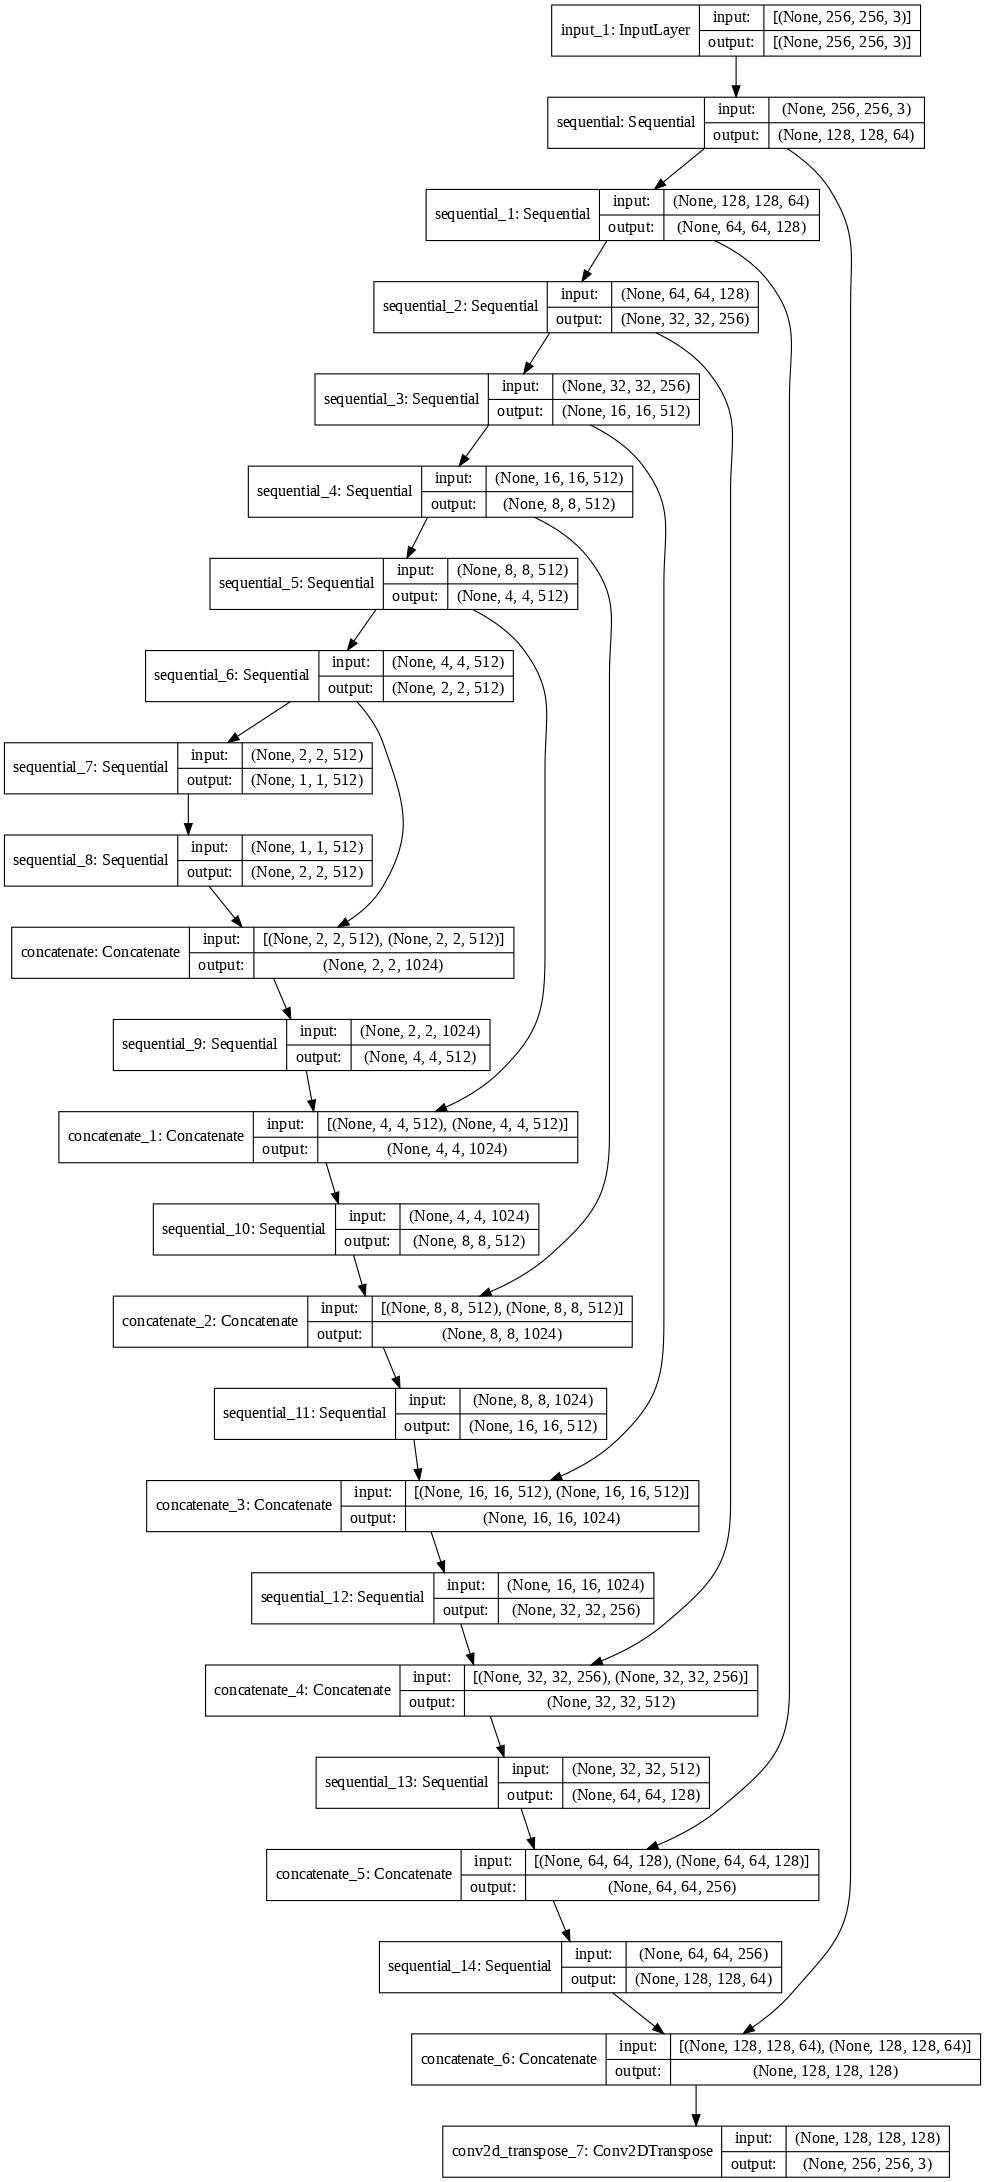

In [ ]:
generator=Generator()
tf.keras.utils.plot_model(generator,show_shapes=True,dpi=80)

In [ ]:
for a in train_dataset_A.take(2):
  print(tf.shape(generator(a)))

tf.Tensor([  1 256 256   3], shape=(4,), dtype=int32)
tf.Tensor([  1 256 256   3], shape=(4,), dtype=int32)


In [ ]:
def Discriminator():
  ini=tf.random_normal_initializer()
  inputs=tf.keras.Input(shape=[256,256,3])
  x=downsample(64,4,"False")(inputs)
  x=downsample(128,4)(x)
  x=downsample(256,4)(x)
  x=tf.keras.layers.ZeroPadding2D()(x)
  x=tf.keras.layers.Conv2D(512,4,1,"valid",kernel_initializer=ini)(x)
  x=InstanceNormalization()(x)
  x=tf.keras.layers.LeakyReLU()(x)
  x=tf.keras.layers.ZeroPadding2D()(x)
  x=tf.keras.layers.Conv2D(1,4,1,"valid",kernel_initializer=ini)(x)
  model=tf.keras.Model(inputs=inputs,outputs=x)
  return model

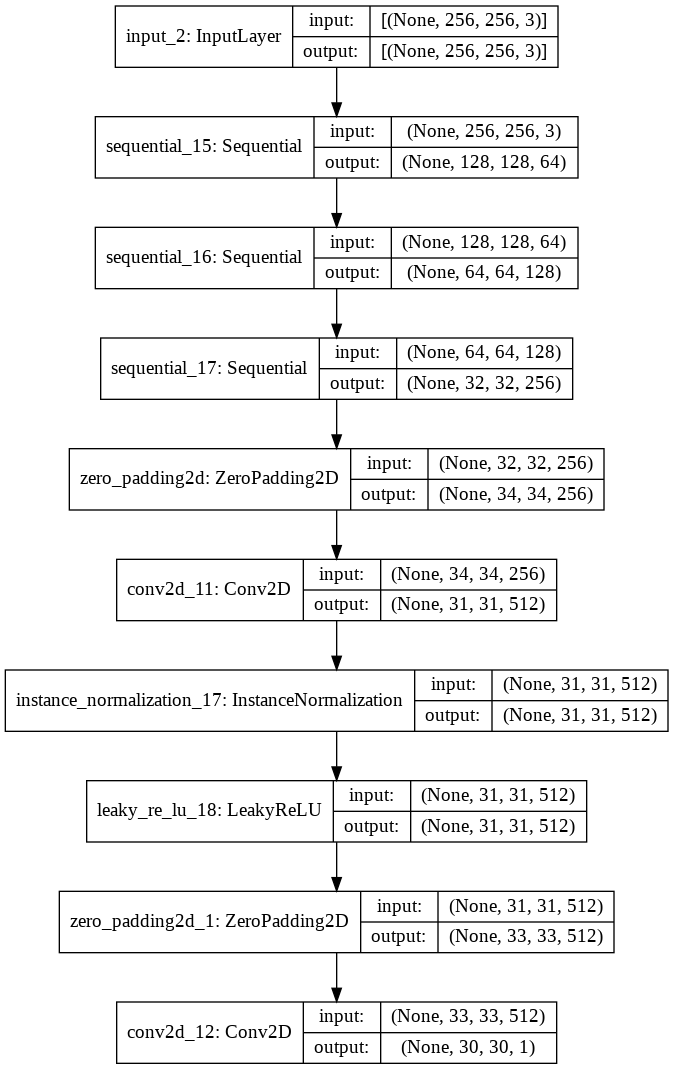

In [ ]:
discriminator=Discriminator()
tf.keras.utils.plot_model(discriminator,show_shapes=True,dpi=96)

In [ ]:
generator_AB=Generator()
generator_BA=Generator()
discriminator_A=Discriminator()
discriminator_B=Discriminator()

In [ ]:
genABoptimizer=tf.keras.optimizers.Adam(2e-4,0.5)
genBAoptimizer=tf.keras.optimizers.Adam(2e-4,0.5)
disAoptimizer=tf.keras.optimizers.Adam(2e-4,0.5)
disBoptimizer=tf.keras.optimizers.Adam(2e-4,0.5)

In [ ]:
# checkpoint_dir="./training_checkpoints"
# checkpoint_prefix=os.path.join(checkpoint_dir,"ckpt")
# checkpoint=tf.train.Checkpoint(genABoptimizer=genABoptimizer,
#                                disAoptimizer=disAoptimizer,
#                                genBAoptimizer=genBAoptimizer,
#                                disBoptimizer=disBoptimizer,
#                                generator_AB=generator_AB,
#                                generator_BA=generator_BA,
#                                discriminator_A=discriminator_A,
#                                discriminator_B=discriminator_B)

In [ ]:
from google.colab import drive
drive.mount("./content/")

Drive already mounted at ./content/; to attempt to forcibly remount, call drive.mount("./content/", force_remount=True).


In [ ]:
checkpoint_path = "/content/content/MyDrive/cycle-gan-weights/"

ckpt=tf.train.Checkpoint(genABoptimizer=genABoptimizer,
                               disAoptimizer=disAoptimizer,
                               genBAoptimizer=genBAoptimizer,
                               disBoptimizer=disBoptimizer,
                               generator_AB=generator_AB,
                               generator_BA=generator_BA,
                               discriminator_A=discriminator_A,
                               discriminator_B=discriminator_B)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=2)

if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
def generate_images(A,B,genAB,genBA):
  def denorm(a):
    return a/2+0.5
  AB=genAB(A)
  BA=genBA(B)
  ABA=genBA(AB)
  BAB=genAB(BA)
  aimgs=[A[0],AB[0],ABA[0]]
  bimgs=[B[0],BA[0],BAB[0]]
  plt.figure(figsize=(30,20))
  for i in range(3):
    plt.subplot(2,3,i+1)
    plt.imshow(denorm(aimgs[i]))
  for i in range(3):
    plt.subplot(2,3,i+4)
    plt.imshow(denorm(bimgs[i]))

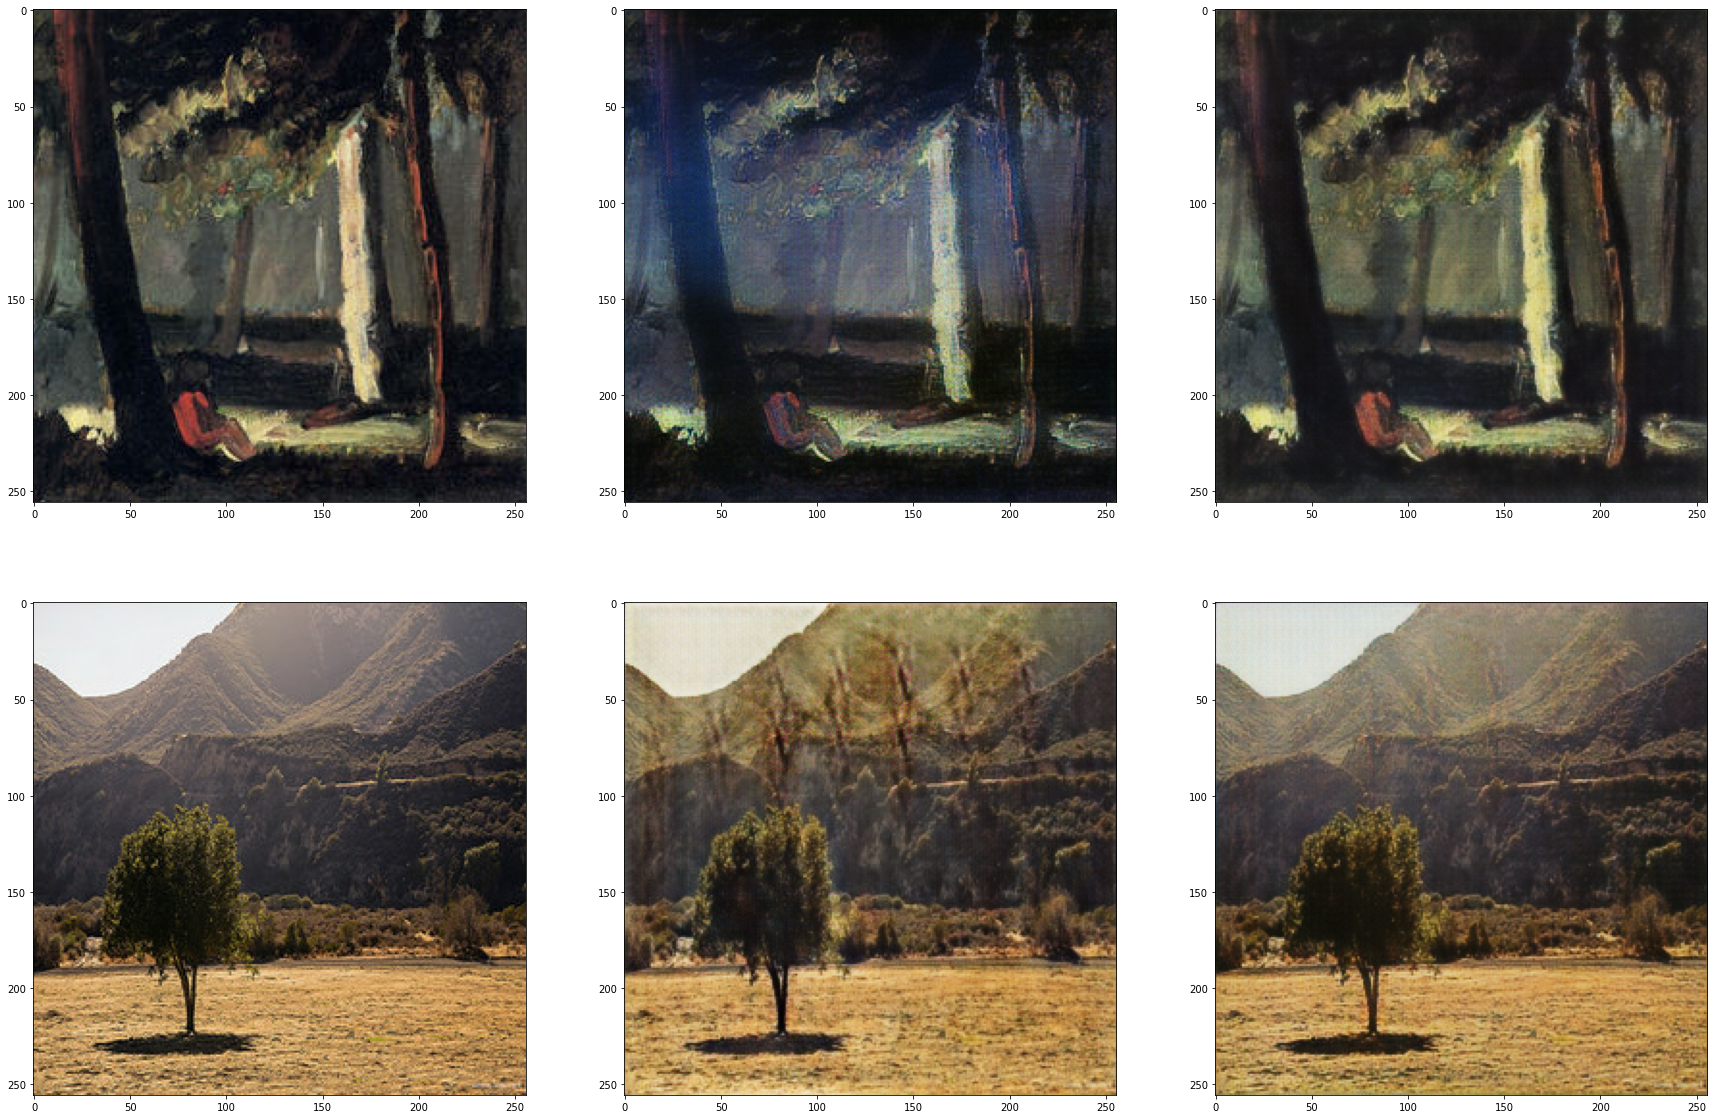

In [ ]:
a=next(iter(test_dataset_A))
b=next(iter(test_dataset_B))
generate_images(a,b,generator_AB,generator_BA)

In [ ]:
loss_obj=tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def gan_loss(generated_disc_output):
  loss=loss_obj(tf.ones_like(generated_disc_output),generated_disc_output)
  return loss

In [ ]:
def cycle_consistency_loss(input,cycled):
  loss=tf.reduce_mean(tf.abs(input-cycled))
  return loss

In [ ]:
def identity_loss(real,same):
 loss=tf.reduce_mean(tf.abs(real-same))
 return loss

In [ ]:
def discriminator_loss(generated,real):
  l1=loss_obj(tf.ones_like(real),real)
  l2=loss_obj(tf.zeros_like(generated),generated)
  return (l1+l2)*0.5

In [ ]:
LAMBDA=10
@tf.function
def train_step(A,B):
  with tf.GradientTape(persistent=True) as tape:

    AB=generator_AB(A,training=True)
    BA=generator_BA(B,training=True)
    ABA=generator_BA(AB,training=True)
    BAB=generator_AB(BA,training=True)

    disc_A_real_output=discriminator_A(A,training=True)
    disc_A_gen_output=discriminator_A(BA,training=True)

    disc_B_real_output=discriminator_B(B,training=True)
    disc_B_gen_output=discriminator_B(AB,training=True)

    same_B=generator_AB(B,training=True)
    same_A=generator_BA(A,training=True)

    total_cycle_loss=cycle_consistency_loss(A,ABA)+cycle_consistency_loss(B,BAB)
    # AB
    AB_ganloss=gan_loss(disc_B_gen_output)
    AB_idloss=identity_loss(B,same_B)
    AB_total_gen_loss=AB_ganloss+(LAMBDA*0.5)*AB_idloss+(LAMBDA*1.0)*total_cycle_loss

    # BA
    BA_ganloss=gan_loss(disc_A_gen_output)
    BA_idloss=identity_loss(A,same_A)
    BA_total_gen_loss=BA_ganloss+(LAMBDA*0.5)*BA_idloss+(LAMBDA*1.0)*total_cycle_loss

    # discriminator
    A_discloss=discriminator_loss(disc_A_gen_output,disc_A_real_output)
    B_discloss=discriminator_loss(disc_B_gen_output,disc_B_real_output)
  
  grads_genAB=tape.gradient(AB_total_gen_loss,generator_AB.trainable_variables)
  grads_genBA=tape.gradient(BA_total_gen_loss,generator_BA.trainable_variables)

  grads_disA=tape.gradient(A_discloss,discriminator_A.trainable_variables)
  grads_disB=tape.gradient(B_discloss,discriminator_B.trainable_variables)

  genABoptimizer.apply_gradients(zip(grads_genAB,generator_AB.trainable_variables))
  genBAoptimizer.apply_gradients(zip(grads_genBA,generator_BA.trainable_variables))

  disAoptimizer.apply_gradients(zip(grads_disA,discriminator_A.trainable_variables))
  disBoptimizer.apply_gradients(zip(grads_disB,discriminator_B.trainable_variables))
  

In [ ]:
def fit(train_dataset_A,train_dataset_B,test_dataset_A,test_dataset_B,steps):
  a=next(iter(test_dataset_A))
  b=next(iter(test_dataset_B))  
  start=time.time()
  for step in range(steps):
    A=next(iter(train_dataset_A))
    B=next(iter(train_dataset_B))  
    if (step+1)%100==0:
      display.clear_output(wait=True)
      print(f'Time taken for 100 steps: {time.time()-start:.2f} sec\n')
      # generate_images(a,b,generator_AB,generator_BA)
      print(f"step : {step+1}")
      start=time.time()
    train_step(A,B)
    if (step+1)%10==0:
      print('.',end='',flush=True)
    if (step+1)%2000==0:
      # checkpoint.save(checkpoint_prefix)
      ckpt_manager.save()
    step+=1

In [ ]:
fit(train_dataset_A,train_dataset_B,test_dataset_A,test_dataset_B,10000)

In [ ]:
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>